# San Francisco Rental Prices Dashboard

In [21]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [22]:
# Read the Mapbox API key and print type
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_token)
print(type(mapbox_token))

<class 'str'>


## Import Data

In [23]:
# Import CVS to Panda
file_path = Path("Resources/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Resources/neighborhoods_coordinates.csv")
neighborhood_locations_df = pd.read_csv(file_path)

### Panel Visualizations

In [24]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_figures = plt.figure()
    housing_units = sfo_data["housing_units"].groupby([sfo_data.index]).mean()
    
    
    fig_housing_units = housing_units.plot(kind='bar', title="Housing Units in San Francisco from 2010 to 2016")
    fig_housing_units.set_ylim(370000,387500)
    fig_housing_units.set_xlabel("Year")
    fig_housing_units.set_ylabel("Housing Units")
    plt.close(housing_figures)
    
    return housing_figures


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    rent_figures = plt.figure()
    gross_rent = sfo_data[["sale_price_sqr_foot","gross_rent"]].groupby([sfo_data.index]).mean()
    
    gross_rent_df = gross_rent["gross_rent"]
    gross_rent_df = gross_rent_df.plot(kind='line', title="Average Gross Rent in San Francisco")
    gross_rent_df.set_xlabel("Year")
    gross_rent_df.set_ylabel("Gross Rent")
    plt.close(rent_figures)

    
    return rent_figures
    
def average_sales_price():
    """Average Sales Price Per Year."""
    
    avg_figures = plt.figure()
    
    gross_rent = sfo_data[["sale_price_sqr_foot","gross_rent"]].groupby([sfo_data.index]).mean()
    gross_rent_df = gross_rent["gross_rent"]
    
    
    sales_price_df = gross_rent["sale_price_sqr_foot"]
    sales_price_df = sales_price_df.plot(kind='line', title="Average Sale Price per Square Foot in San Francisco")
    sales_price_df.set_xlabel("Year")
    sales_price_df.set_ylabel("Avg. Sale Price")
    plt.close(avg_figures)
    
    return avg_figures
    


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    neighborhood_df = sfo_data.drop(columns=["housing_units","gross_rent"])
    neighborhood_df = neighborhood_df.groupby([sfo_data.index,'neighborhood']).mean()
    neighborhood_df = neighborhood_df.reset_index()
    
    return neighborhood_df.hvplot.line(
    'year',
    'sale_price_sqr_foot',
    groupby = 'neighborhood',
    xlabel="Year",
    ylabel="Avg. Sale Price per. Square foot")

    choose_neighborhood(neighborhood_df)

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    expensive_sales_df = sfo_data
    expensive_sales_df = expensive_sales_df.groupby(['neighborhood']).mean()
    expensive_sales_df = expensive_sales_df.nlargest(10, 'sale_price_sqr_foot')
    expensive_sales_df

    expensive_sales_df = expensive_sales_df.hvplot.bar(
    'neighborhood',
    'sale_price_sqr_foot',
    xlabel="Neighborhood",
    ylabel="Avg. Sale Price per. Square foot",
    title='Top 10 Expensive Neighborhoods in SFO',
    rot=90)
    
    return expensive_sales_df

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    expensive_sales_df = sfo_data
    expensive_sales_df = expensive_sales_df.groupby(['neighborhood']).mean()
    expensive_sales_df = expensive_sales_df.nlargest(10, 'sale_price_sqr_foot')
    expensive_sales_df
    
    expensive_sales_df = expensive_sales_df.reset_index()
    expensive_sales_df = px.parallel_coordinates(expensive_sales_df, color = 'sale_price_sqr_foot')
    
    return expensive_sales_df


def parallel_categories():
    """Parallel Categories Plot."""
    
    expensive_sales_df = sfo_data
    expensive_sales_df = expensive_sales_df.groupby(['neighborhood']).mean()
    expensive_sales_df = expensive_sales_df.nlargest(10, 'sale_price_sqr_foot')
    
    expensive_sales_df = expensive_sales_df.reset_index()
    
    expensive_sales_df = px.parallel_categories(
    expensive_sales_df,
    dimensions=["neighborhood","sale_price_sqr_foot","housing_units","gross_rent"],
    color= "sale_price_sqr_foot"
)
    return expensive_sales_df

def neighborhood_map():
    """Neighborhood Map"""
    
    avg_sales_df = sfo_data
    avg_sales_df = avg_sales_df.groupby(['neighborhood']).mean()
    avg_sales_df = avg_sales_df.reset_index()
    
    joined_df = (
    pd.concat([neighborhood_locations_df, avg_sales_df], axis=1, sort=True)
    .dropna()
)
    joined_plot = px.scatter_mapbox(
        joined_df,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco"
)
    
    
    
    
    return joined_plot

### Panel Dashboard

In [25]:
# Create Welcome Panel
welcome_column = pn.Column(
    "###### This dashboard presents a visual analysis of historical prices of house units, sale per square foot and gross rent in San Francisco, California from 2010 to 2016. You can navigate through the tabs above to explore more details about the evolution of the real estate market on the Golden city across these years.",
    neighborhood_map()
)

In [26]:
# Create Market Analysis Panel
yearly_market_column = pn.Row(
    "Yearly Market Analysis",
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price()
)

In [27]:
# Create Neighborhood Analysis Panel
neighborhood_column = pn.Column(
    "Neighborhood Analysis",
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods()
)

In [28]:
# Create Parallel Panel
parallel_plots_column = pn.Column(
    "Parallel Plots Analysis",
    parallel_coordinates(),
    parallel_categories()
)

In [29]:
# Create Tabs
sanfrancisco_dashboard = pn.Tabs(
    ("Welcome", welcome_column),
    ("Yearly Market Analysis",yearly_market_column),
    ("Neighborhood",neighborhood_column),
    ("Parallel Plots Analysis",parallel_plots_column)
)

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Row
        [0] Markdown(str)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
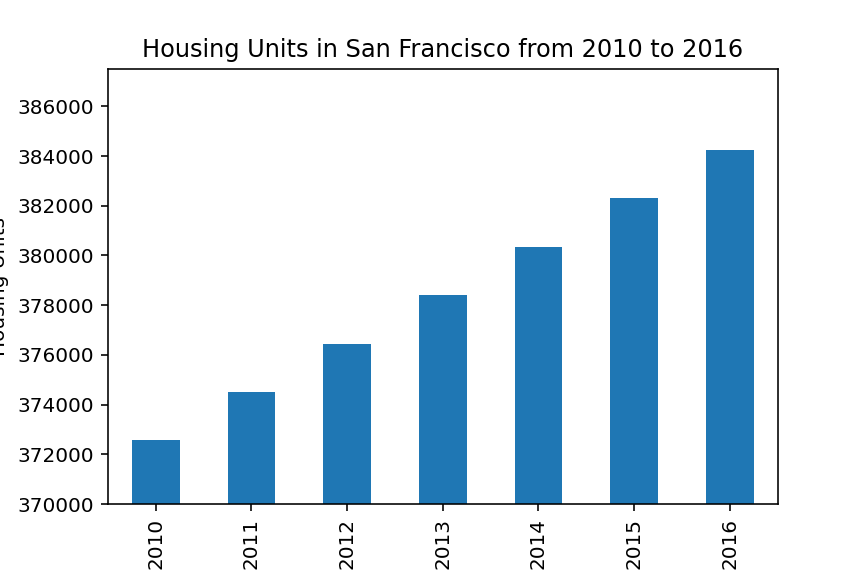
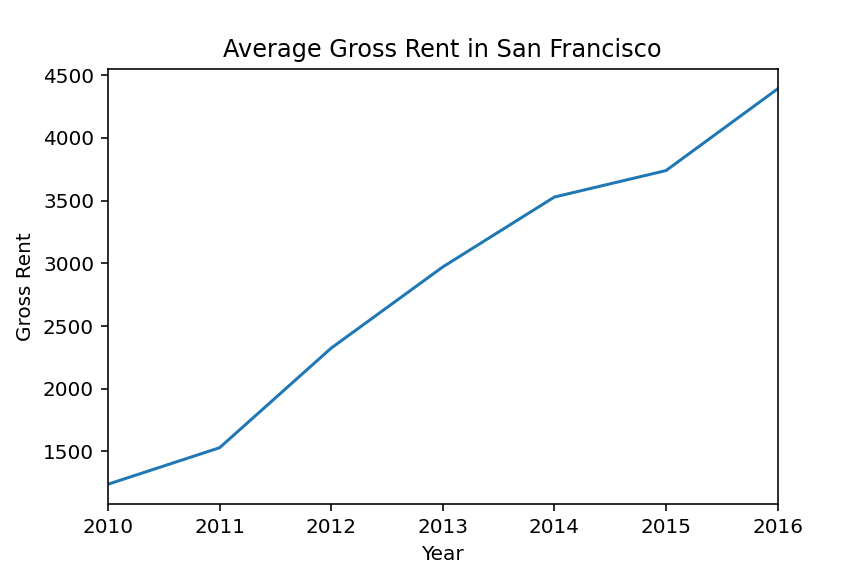
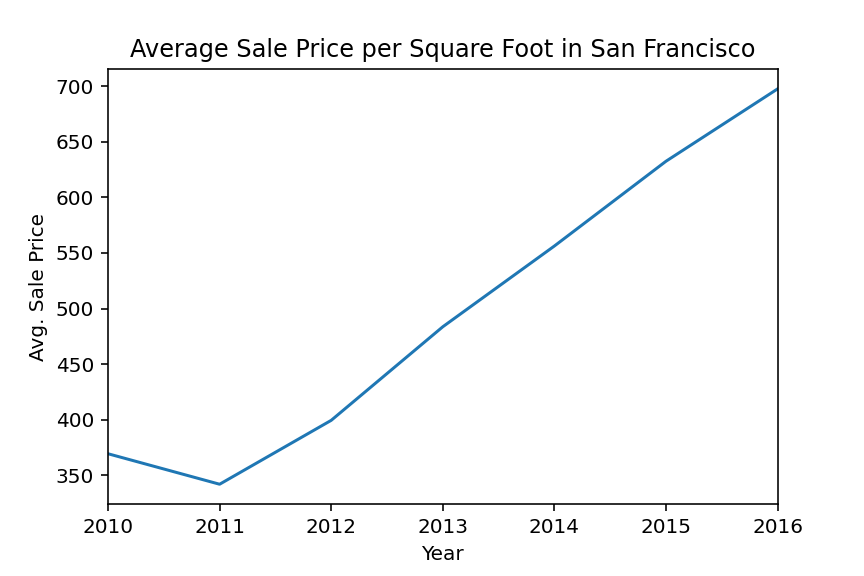

In [30]:
sanfrancisco_dashboard.servable()